In [3]:
pip install tensorflow numpy matplotlib opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os

In [9]:
class ManipulationTraceLayer(layers.Layer):
    def __init__(self, kernel_size=(3, 3), **kwargs):
        super(ManipulationTraceLayer, self).__init__()
        self.kernel_size = kernel_size
        self.filters = 1  # Output will have 1 channel representing manipulation trace

    def build(self, input_shape):
        # Create trainable kernel for manipulation trace extraction
        self.kernel = self.add_weight(shape=tuple(self.kernel_size) + (input_shape[-1], self.filters),
                              initializer='glorot_uniform',
                              trainable=True)


    def call(self, inputs):
        return tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

# Example usage:
input_image = tf.random.normal([1, 128, 128, 3])  # 1 sample of 128x128 image with 3 channels
manipulation_trace_layer = ManipulationTraceLayer()
trace_output = manipulation_trace_layer(input_image)

In [4]:
def build_amtennet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Step 1: Manipulation trace extraction layer
    x = ManipulationTraceLayer(kernel_size=(3, 3))(inputs)

    # Step 2: Convolutional layers for feature extraction
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Step 3: Fully connected layers for classification
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Build the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Example of creating the model
model = build_amtennet((128, 128, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ manipulation_trace_layer_1           │ (None, 128, 128, 1)         │              27 │
│ (ManipulationTraceLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,481,820 (32.36 MB)

 Trainable params: 8,481,820 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_dataset(real_dir, fake_dir, target_size=(128, 128)):
    real_images = [preprocess_image(os.path.join(real_dir, fname), target_size) for fname in os.listdir(real_dir)]
    fake_images = [preprocess_image(os.path.join(fake_dir, fname), target_size) for fname in os.listdir(fake_dir)]

    X = np.array(real_images + fake_images)
    y = np.array([0] * len(real_images) + [1] * len(fake_images))  # 0 for real, 1 for fake

    # Shuffle the dataset
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    return X, y

# Load and preprocess data
real_images_dir = '/content/drive/MyDrive/dataset/real'
fake_images_dir = '/content/drive/MyDrive/dataset/fake'
X, y = load_dataset(real_images_dir, fake_images_dir)

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.5477 - loss: 0.7223 - val_accuracy: 0.6196 - val_loss: 0.6728
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6225 - loss: 0.6587 - val_accuracy: 0.6596 - val_loss: 0.6191
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6849 - loss: 0.5929 - val_accuracy: 0.7192 - val_loss: 0.5537
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7681 - loss: 0.4841 - val_accuracy: 0.7869 - val_loss: 0.4613
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8523 - loss: 0.3490 - val_accuracy: 0.8661 - val_loss: 0.3197
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9115 - loss: 0.2153 - val_accuracy: 0.9110 - val_loss: 0.2478
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9603 - loss: 0.1232 - val_accuracy: 0.9502 - val_loss: 0.1839
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9829 - loss: 0.0631 - val_ac

In [9]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9590 - loss: 0.1507
Validation Accuracy: 96.08%


In [10]:
model.save('amtennet_deepfake_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


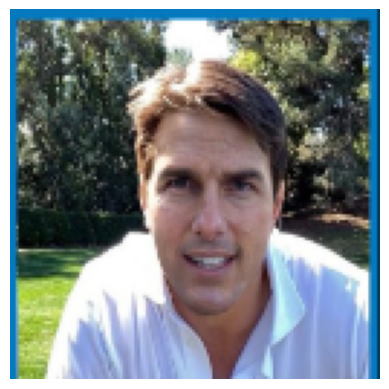

Deepfake detected!


In [30]:
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('amtennet_deepfake_model.h5', custom_objects={'ManipulationTraceLayer': ManipulationTraceLayer})

# Preprocess a new image
new_image = preprocess_image('/content/tom_cruise.png')
new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension

# Predict if the image is real or deepfake
prediction = model.predict(new_image)

# Display the image
plt.imshow(new_image[0])
plt.axis('off')
plt.show()

if prediction >= 0.5:
    print("Deepfake detected!")
else:
    print("Real image!")
